<a href="https://colab.research.google.com/github/jairorodriguezarias/matching_engine_create_multimodal_embeddings/blob/main/vector_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [1]:


# Install the packages
! pip3 install --upgrade google-cloud-aiplatform \
                         google-cloud-storage

! pip install google-cloud-vision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.5/120.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.0/321.0 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.17.3
    Uninstalling google-auth-2.17.3:
      Successfully uninstalled google-auth-2.17.3
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 2.8.0
    Uninstalling google-cloud-storage-2.8.0:
      Successfully uninstalled google-cloud-storage-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-auth==2.17.3, but you have google-auth 2.23.3 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 8.8 MB/s eta 0:00:00


In [2]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

# Configuration


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [12]:
PROJECT_ID = "genai-387907"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


In [13]:
REGION = "us-central1"  # @param {type: "string"}

Cloud Storage

In [14]:
BUCKET_NAME = "vector_store"

In [15]:
BUCKET_URI = f"gs://{BUCKET_NAME}-{PROJECT_ID}-unique"  # @param {type:"string"}

In [ ]:
# Only if your bucket doesn't exist
# ! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

In [34]:
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://vector_store-genai-387907-unique/images/* ./images

Copying gs://vector_store-genai-387907-unique/images/0478630300_1_1_1.jpg...
Copying gs://vector_store-genai-387907-unique/images/0485561712_6_1_1.jpg...
Copying gs://vector_store-genai-387907-unique/images/1165680701_1_1_1.jpg...
/ [3 files][  1.9 MiB/  1.9 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://vector_store-genai-387907-unique/images/1880531802_6_1_1.jpg...
Copying gs://vector_store-genai-387907-unique/images/2308012712_1_1_1.jpg...
Copying gs://vector_store-genai-387907-unique/images/2727206620_1_1_1.jpg...
Copying gs://vector_store-genai-387907-unique/images/4365304406_6_1_1.jpg...
Copying gs://vector_store-genai-387907-unique/images/8370728704_1_1_1 (1).jpg...
Copying gs://vector_store-genai-387907-unique/i

In [35]:
image_directory = "/content/images"

# Cloud Vision Embeddings

In [3]:
import os

In [25]:
image_names = ['0478630300_1_1_1.jpg', '0485561712_6_1_1.jpg', '1165680701_1_1_1.jpg']

image_paths = [os.path.join(image_directory, image_name) for image_name in image_names]

print(image_paths)

['/content/images/0478630300_1_1_1.jpg', '/content/images/0485561712_6_1_1.jpg', '/content/images/1165680701_1_1_1.jpg']


Perform rate-limited explicit image detection

In [36]:

import time
from concurrent.futures import ThreadPoolExecutor
from typing import Optional

import numpy as np
from tqdm import tqdm

# Create a rate limiter with a limit of 1800 requests per minute
seconds_per_job = 1 / (1800 / 60)


def process_image(image_path: str) -> Optional[bool]:
    try:
        annotation = detect_safe_search(image_path)

        if annotation:
            return convert_annotation_to_safety(safe_search_annotation=annotation)
        else:
            return None
    except Exception:
        return None


# Process images using ThreadPool
is_safe_values_cloud_vision = []
with ThreadPoolExecutor() as executor:
    futures = []
    for img_url in tqdm(image_paths, total=len(image_paths), position=0):
        futures.append(executor.submit(process_image, img_url))
        time.sleep(seconds_per_job)

    for future in futures:
        is_safe_values_cloud_vision.append(future.result())

# Set Nones to False
is_safe_values_cloud_vision = [
    is_safe or False for is_safe in is_safe_values_cloud_vision
]

# Print number of safe images found
print(
    f"Safe images = {np.array(is_safe_values_cloud_vision).sum()} out of {len(is_safe_values_cloud_vision)} images"
)

100%|██████████| 3/3 [00:00<00:00, 29.25it/s]

Safe images = 0 out of 3 images


Defining encoding functions


In [27]:
import base64
import time
import typing

from google.cloud import aiplatform
from google.protobuf import struct_pb2


class EmbeddingResponse(typing.NamedTuple):
    text_embedding: typing.Sequence[float]
    image_embedding: typing.Sequence[float]


def load_image_bytes(image_uri: str) -> bytes:
    """Load image bytes from a remote or local URI."""
    image_bytes = None
    if image_uri.startswith("http://") or image_uri.startswith("https://"):
        response = requests.get(image_uri, stream=True)
        if response.status_code == 200:
            image_bytes = response.content
    else:
        image_bytes = open(image_uri, "rb").read()
    return image_bytes


class EmbeddingPredictionClient:
    """Wrapper around Prediction Service Client."""

    def __init__(
        self,
        project: str,
        location: str = "us-central1",
        api_regional_endpoint: str = "us-central1-aiplatform.googleapis.com",
    ):
        client_options = {"api_endpoint": api_regional_endpoint}
        # Initialize client that will be used to create and send requests.
        # This client only needs to be created once, and can be reused for multiple requests.
        self.client = aiplatform.gapic.PredictionServiceClient(
            client_options=client_options
        )
        self.location = location
        self.project = project

    def get_embedding(self, text: str = None, image_file: str = None):
        if not text and not image_file:
            raise ValueError("At least one of text or image_file must be specified.")

        # Load image file
        image_bytes = None
        if image_file:
            image_bytes = load_image_bytes(image_file)

        instance = struct_pb2.Struct()
        if text:
            instance.fields["text"].string_value = text

        if image_bytes:
            encoded_content = base64.b64encode(image_bytes).decode("utf-8")
            image_struct = instance.fields["image"].struct_value
            image_struct.fields["bytesBase64Encoded"].string_value = encoded_content

        instances = [instance]
        endpoint = (
            f"projects/{self.project}/locations/{self.location}"
            "/publishers/google/models/multimodalembedding@001"
        )
        response = self.client.predict(endpoint=endpoint, instances=instances)

        text_embedding = None
        if text:
            text_emb_value = response.predictions[0]["textEmbedding"]
            text_embedding = [v for v in text_emb_value]

        image_embedding = None
        if image_bytes:
            image_emb_value = response.predictions[0]["imageEmbedding"]
            image_embedding = [v for v in image_emb_value]

        return EmbeddingResponse(
            text_embedding=text_embedding, image_embedding=image_embedding
        )

Create helper functions to process data in batches

In [28]:
import time
from concurrent.futures import ThreadPoolExecutor
from typing import Callable, Generator, List

from tqdm.auto import tqdm


def generate_batches(
    inputs: List[str], batch_size: int
) -> Generator[List[str], None, None]:
    """
    Generator function that takes a list of strings and a batch size, and yields batches of the specified size.
    """

    for i in range(0, len(inputs), batch_size):
        yield inputs[i : i + batch_size]


API_IMAGES_PER_SECOND = 2


def encode_to_embeddings_chunked(
    process_function: Callable[[List[str]], List[Optional[List[float]]]],
    items: List[str],
    batch_size: int = 1,
) -> List[Optional[List[float]]]:
    """
    Function that encodes a list of strings into embeddings using a process function.
    It takes a list of strings and returns a list of optional lists of floats.
    The data is processed in chunks to prevent out-of-memory errors.
    """

    embeddings_list: List[Optional[List[float]]] = []

    # Prepare the batches using a generator
    batches = generate_batches(items, batch_size)

    seconds_per_job = batch_size / API_IMAGES_PER_SECOND

    with ThreadPoolExecutor() as executor:
        futures = []
        for batch in tqdm(batches, total=len(items) // batch_size, position=0):
            futures.append(executor.submit(process_function, batch))
            time.sleep(seconds_per_job)

        for future in futures:
            embeddings_list.extend(future.result())
    return embeddings_list


Create functions that wrap embedding functions in try-except and retry logic.

In [29]:
import copy
from typing import List, Optional

import numpy as np
import requests
from tenacity import retry, stop_after_attempt

client = EmbeddingPredictionClient(project=PROJECT_ID)


# Use a retry handler in case of failure
@retry(reraise=True, stop=stop_after_attempt(3))
def encode_texts_to_embeddings_with_retry(text: List[str]) -> List[List[float]]:
    assert len(text) == 1

    try:
        return [client.get_embedding(text=text[0], image_file=None).text_embedding]
    except Exception:
        raise RuntimeError("Error getting embedding.")


def encode_texts_to_embeddings(text: List[str]) -> List[Optional[List[float]]]:
    try:
        return encode_texts_to_embeddings_with_retry(text=text)
    except Exception:
        return [None for _ in range(len(text))]


@retry(reraise=True, stop=stop_after_attempt(3))
def encode_images_to_embeddings_with_retry(image_uris: List[str]) -> List[List[float]]:
    assert len(image_uris) == 1

    try:
        return [
            client.get_embedding(text=None, image_file=image_uris[0]).image_embedding
        ]
    except Exception as ex:
        print(ex)
        raise RuntimeError("Error getting embedding.")


def encode_images_to_embeddings(image_uris: List[str]) -> List[Optional[List[float]]]:
    try:
        return encode_images_to_embeddings_with_retry(image_uris=image_uris)
    except Exception as ex:
        print(ex)
        return [None for _ in range(len(image_uris))]


Test the encoding function

In [37]:
%%time
# Encode a sample subset of images
image_paths_filtered = list(image_paths)[:1000]
image_embeddings = encode_to_embeddings_chunked(
    process_function=encode_images_to_embeddings, items=image_paths_filtered
)

# Keep only non-None embeddings
indexes_to_keep, image_embeddings = zip(
    *[
        (index, embedding)
        for index, embedding in enumerate(image_embeddings)
        if embedding is not None
    ]
)

print(f"Processed {len(indexes_to_keep)} embeddings successfully")


100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


Processed 3 embeddings successfully
CPU times: user 65.1 ms, sys: 18.7 ms, total: 83.8 ms
Wall time: 4.26 s


In [38]:
import numpy as np


def dot_product_distance(
    text_embedding: np.ndarray, image_embeddings: np.ndarray
) -> np.ndarray:
    """Compute dot-product distance between text and image embeddings by taking the dot product"""
    return np.dot(text_embedding, image_embeddings.T)


<class 'list'>
<class 'float'>
<class 'tuple'>
<class 'list'>


IndexError: ignored

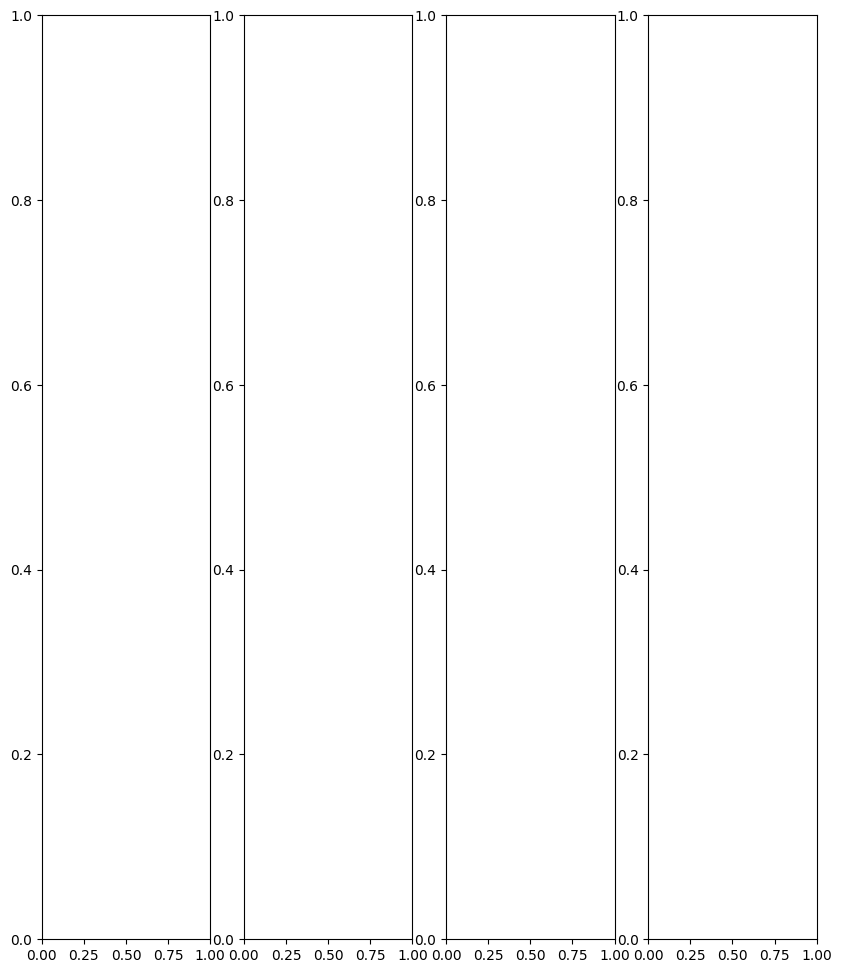

In [40]:
import math
from io import BytesIO

import matplotlib.pyplot as plt
from PIL import Image

text_query = "Birds in flight"

# Calculate text embedding of query
text_embedding = encode_texts_to_embeddings(text=[text_query])[0]

print(type(text_embedding))
print(type(text_embedding[0]))

print(type(image_embeddings))
print(type(image_embeddings[0]))

# Calculate distance
distances = dot_product_distance(
    text_embedding=np.array(text_embedding), image_embeddings=np.array(image_embeddings)
)

# Set the maximum number of images to display
MAX_IMAGES = 20

# Sort images and scores by descending order of scores and select the top max_images
sorted_data = sorted(
    zip(image_paths_filtered, distances), key=lambda x: x[1], reverse=True
)[:MAX_IMAGES]

# Calculate the number of rows and columns needed to display the images
num_cols = 4
num_rows = math.ceil(len(sorted_data) / num_cols)


# Create a grid of subplots to display the images
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))

# Loop through the top max_images images and display them in the subplots
for i, (image_path, distance) in enumerate(sorted_data):
    # Calculate the row and column index for the current image
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Check if image_path is a remote URL
    if image_path.startswith("http://") or image_path.startswith("https://"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)

    # Display the image in the current subplot
    axs[row_idx, col_idx].imshow(image, cmap="gray")

    # Set the title of the subplot to the image index and score
    axs[row_idx, col_idx].set_title(f"Rank {i+1}, Distance = {distance:.2f}")

    # Remove ticks from the subplot
    axs[row_idx, col_idx].set_xticks([])
    axs[row_idx, col_idx].set_yticks([])

# Adjust the spacing between subplots and display the plot
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

In [41]:
DIMENSIONS = len(text_embedding)

print(DIMENSIONS)

1408


Save the embedding in JSONL formt

In [42]:
import tempfile

# Create temporary file to write embeddings to
embeddings_file = tempfile.NamedTemporaryFile(suffix=".json", delete=False)

embeddings_file.name

'/tmp/tmpi179zrvt.json'

In [43]:
import json

BATCH_SIZE = 1000

with open(embeddings_file.name, "a") as f:
    for i in tqdm(range(0, len(image_names), BATCH_SIZE)):
        image_names_chunk = image_names[i : i + BATCH_SIZE]
        image_paths_chunk = image_paths[i : i + BATCH_SIZE]

        embeddings = encode_to_embeddings_chunked(
            process_function=encode_images_to_embeddings, items=image_paths_chunk
        )

        # Append to file
        embeddings_formatted = [
            json.dumps(
                {
                    "id": str(id),
                    "embedding": [str(value) for value in embedding],
                }
            )
            + "\n"
            for id, embedding in zip(image_names_chunk, embeddings)
            if embedding is not None
        ]
        f.writelines(embeddings_formatted)

100%|██████████| 1/1 [00:04<00:00,  4.06s/it]


Upload the training data to Cloud Storage

In [44]:
UNIQUE_FOLDER_NAME = "embeddings_folder_unique"
EMBEDDINGS_INITIAL_URI = f"{BUCKET_URI}/{UNIQUE_FOLDER_NAME}/"
! gsutil cp {embeddings_file.name} {EMBEDDINGS_INITIAL_URI}

Copying file:///tmp/tmpi179zrvt.json [Content-Type=application/json]...
-
Operation completed over 1 objects/68.9 KiB.                                     
